In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

['ratings.csv', 'links.csv', 'tags.csv', 'README.txt', 'movies.csv']


In [2]:
ratings = pd.read_csv('../input/ratings.csv')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
ratings.shape

(100004, 4)

In [4]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()
n_user = len(users)
n_movie =  len(movies)
print(n_user , n_movie)

671 9066


### Grouping the userId who is fondest for movies and rates the most.

In [5]:
ratings["userId"].value_counts().sort_values(ascending=False)[0:15]

547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
294     947
509     923
580     922
213     910
212     876
Name: userId, dtype: int64

### Grouping the top movies that are rated by the most of the users. The visualizations are being performed in other notebook.

In [6]:
ratings["movieId"].value_counts().sort_values(ascending=False)[0:15]

356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
1196    234
110     228
1270    226
608     224
2858    220
Name: movieId, dtype: int64

In [7]:
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#le.fit(ratings.userId)
#temp = le.transform(ratings.userId)
#print(temp)

In [8]:
#ratings.userId = temp

#### Making dictionary and encoding the label or Ids manually.

In [9]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
ratings['userId'] = ratings['userId'].apply(lambda x: userid2idx[x])
ratings['movieId'] = ratings['movieId'].apply(lambda x: movieid2idx[x])

In [10]:
#movieid2idx = {o:i for i,o in enumerate(movies)}
#ratings['movieId'] = ratings['movieId'].apply(lambda x: movieid2idx[x])

#### Splitting the total size randomly to train and valid. 

In [11]:
split = np.random.rand(len(ratings)) < 0.8
train = ratings[split]
valid = ratings[~split]

In [12]:
print(train.shape , valid.shape)

(80006, 4) (19998, 4)


In [13]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2 , l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [57]:
filepath="recommend_weights.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

### Checkpointing the model before overfitting and in this case I have used an embedding layer of 50 as latent vector size. 

In [58]:
factor =50
user_input = Input(shape=(1,), dtype='int64', name='user_input')
user_emb = Embedding(n_user, factor, input_length=1, W_regularizer=l2(1e-4))(user_input)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, input_length=1, embeddings_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


### Input -> Embedding layer -> merging -> remaining neural net

In [59]:
movie_input = Input(shape=(1,), dtype='int64', name='movie_input')
movie_emb = Embedding(n_movie, factor, input_length=1, W_regularizer=l2(1e-4))(movie_input)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, input_length=1, embeddings_regularizer=<keras.reg...)`
  


#### Also taking the biases into account.

In [60]:
user_bias =  Embedding(n_user, 1, input_length = 1)(user_input)
user_bias = Flatten()(user_bias)
movie_bias = Embedding(n_movie, 1, input_length =1)(movie_input)
movie_bias = Flatten()(movie_bias)

In [70]:
lr =0.0004
# Building a linear model
inp = merge([user_emb, movie_emb], mode = 'dot')
inp = Flatten()(inp)
inp = keras.layers.add(([inp, user_bias]))
inp = Dense(16 , activation = 'relu')(inp)
inp = Dropout(0.4)(inp)
inp = Dense(1)(inp)
inp = keras.layers.add(([inp, movie_bias]))
model = Model([user_input, movie_input], inp)
model.compile(Adam(lr), loss = 'mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        33550       user_input[0][0]                 
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 50)        453300      movie_input[0][0]                
__________________________________________________________________________________________________
merge_37 (

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [71]:
history = model.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=15, 
          validation_data=([valid.userId, valid.movieId], 
            valid.rating) , callbacks=[checkpoint])

Train on 80006 samples, validate on 19998 samples
Epoch 1/15
80006/80006 [==============================] - 6s 70us/step - loss: 8.2319 - val_loss: 4.8647

Epoch 00001: val_loss did not improve
Epoch 2/15
80006/80006 [==============================] - 4s 56us/step - loss: 2.5080 - val_loss: 1.1638

Epoch 00002: val_loss did not improve
Epoch 3/15
80006/80006 [==============================] - 4s 56us/step - loss: 1.6487 - val_loss: 1.0114

Epoch 00003: val_loss did not improve
Epoch 4/15
80006/80006 [==============================] - 5s 57us/step - loss: 1.5370 - val_loss: 0.9668

Epoch 00004: val_loss did not improve
Epoch 5/15
80006/80006 [==============================] - 4s 56us/step - loss: 1.4556 - val_loss: 0.9375

Epoch 00005: val_loss did not improve
Epoch 6/15
80006/80006 [==============================] - 4s 56us/step - loss: 1.3764 - val_loss: 0.9213

Epoch 00006: val_loss did not improve
Epoch 7/15
80006/80006 [==============================] - 4s 56us/step - loss: 1.3062 

### Till now the mean square is 0.84852 but still their is scope for more improvement ....

### Further reducing the learning rate and thus improving more and achieving mean square error of 0.8375

In [75]:
model.optimizer.lr = 0.00001
history1 = model.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=3, 
          validation_data=([valid.userId, valid.movieId], 
            valid.rating))

Train on 80006 samples, validate on 19998 samples
Epoch 1/3
80006/80006 [==============================] - 4s 52us/step - loss: 0.7230 - val_loss: 0.8394
Epoch 2/3
80006/80006 [==============================] - 5s 57us/step - loss: 0.6947 - val_loss: 0.8373
Epoch 3/3
80006/80006 [==============================] - 4s 56us/step - loss: 0.6729 - val_loss: 0.8375


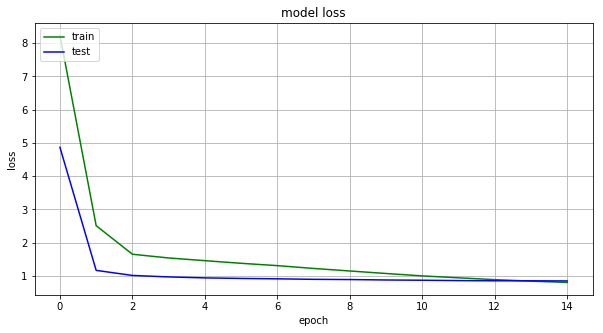

In [78]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [83]:
toprate = ratings.groupby('movieId')['rating'].count()
topMovies = toprate.sort_values(ascending=False)[:3000]
topMovies = np.array(topMovies.index)

In [84]:
get_movie_emb = Model(movie_input, movie_emb)
movie_embedding = np.squeeze(get_movie_emb.predict([topMovies]))
movie_embedding.shape

(3000, 50)

In [93]:
movie_embedding[0:7,0:15]

array([[-0.07672875, -0.07663365, -0.0465707 ,  0.13321915,  0.00865331,
        -0.03406987,  0.10273724, -0.02132043,  0.06384712, -0.16259816,
         0.10340292, -0.10185062, -0.04102888, -0.01525759, -0.19752127],
       [ 0.02856897,  0.00820881, -0.02559759, -0.07349861,  0.01045733,
         0.1531114 , -0.04459317,  0.10907005, -0.07003485,  0.04661378,
         0.04710352, -0.16994552,  0.19181763, -0.03779722, -0.01768016],
       [ 0.00974791, -0.0021386 , -0.01588316,  0.09841032, -0.05034545,
         0.06117765, -0.00687807,  0.05834039,  0.04245455,  0.06375655,
         0.09261705, -0.03817103, -0.0387565 , -0.05116206,  0.05962013],
       [ 0.12208578,  0.08781894, -0.09137188,  0.18379325, -0.0031487 ,
         0.04189131, -0.13069619,  0.14918318,  0.05960361, -0.05869122,
         0.0019134 , -0.07659383,  0.10560706,  0.0049676 ,  0.06587296],
       [ 0.05369265,  0.06730427, -0.15658881, -0.12114594, -0.03897894,
        -0.03314263,  0.07984608, -0.06418684, 

In [87]:
pred = model.predict([valid.userId, valid.movieId])

In [89]:
print(pred.shape)

(19998, 1)

#### Predicting the ratings for the valid set

In [90]:
print(pred)

[[3.349411 ]
 [3.4059608]
 [2.744988 ]
 ...
 [4.0520964]
 [4.8035803]
 [3.7002375]]
